
## Comparing the Performance of Non-bagged and Bagged Regression Methods Applied to a High Dimensional and Sparse Dataset

# Keivan Khaleghi
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Misael Morales, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/misaelmmorales/)

#### Course TA: Midé Mabadeje, Graduate Student, The University of Texas at Austin


### Executive Summary

 
In this excrcise, we evaluate the predictive performance of several regression methods when applied to a high dimensional predictor feature space. The focus is to evalute the performance of bagged and non-bagged methods when the high dimensional space is also sparse i.e. the predictor feature space is not sampled sufficiently. This will provide guidance on the potential advantages of bagged methods when dealing with high dimensional and sparse datasets.

A synthetic dataset was created using simulation runs from [GEOPHIRES](https://github.com/NREL/GEOPHIRES-v2) model. This package was developed by researchers at the National Renewable Energy laboratory to perform techno-econnomic analysis on geothermal plants for electrical and thermal power generation purposes. There are multiple subsurface parameters in this model that facilitate the modeling of the reservoir. We will train several regression models to predict the levelized cost of electricity _(LCOE)_ as the output.

We will show that overall bagged methods perform better than non-bagged methods when applied to this dataset. Moreover, bootstrapping the training/testing data and assessing the predictive performance of the bootstrapped model provides us with a confidence interval on the quality of the fit. We offer the following recommendation: consider using bagged/ensemble methods and bootstrapping as these methods essentially densify the initial sparse predictor feature space. The performance of the polynomial regressor both in its non-bagged and bagged forms deserves further investigation.  

### 0.  Import Packages and the Dataset

In [1]:
import numpy as np                                                    # import nummpy
import pandas as pd                                                  # import pandas  
import matplotlib.pyplot as plt                                     # import plotting module
import seaborn as sb                                               #import seaborne for correlation and pairwise plots
from sklearn.linear_model import LinearRegression                 #import linear regression from scikitlearn
from sklearn.linear_model import Ridge, RidgeCV, Lasso           #import lasso, ridge regression
from sklearn.preprocessing import MinMaxScaler                  # normalize data to [0,1] interval
from sklearn.preprocessing import StandardScaler               # the other famous transform [-1,1]
from sklearn.model_selection import train_test_split          # train, test split of data
from sklearn.utils import resample                           # package used for bootstrapping
from sklearn.model_selection import GridSearchCV              #gridsearch for hyperparameter optimization
from sklearn.linear_model import ElasticNet, ElasticNetCV      # elastic net (both L1 and L2 regularization included)
from sklearn.tree import DecisionTreeRegressor                  # Decision tree package
from sklearn.ensemble import BaggingRegressor                    # wrapper for bagging operation
from sklearn.preprocessing import PolynomialFeatures              # feature used for polynomial regression
from sklearn.ensemble import RandomForestRegressor                 # ensemble random forest method
from sklearn.pipeline import make_pipeline                          # make pipelines baby!
from sklearn.pipeline import Pipeline                         
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score                           # coeff. of determination score aka R^2
from sklearn.model_selection import RepeatedKFold            # for cross validation

### *Load Data*

The following workflow applies to the Excel file "test4.xlsx". The dataset is publicly available [here](https://docs.google.com/spreadsheets/d/1MrWFyFHgERZHp6o4ojsciA3S3FMtyMl8/edit?usp=share_link&ouid=102663070458440109915&rtpof=true&sd=true)  

We used the GEOPHIRES program to simulate the operation of a powerplant coupled with a [hydrothermal resource](https://www.energy.gov/eere/geothermal/hydrothermal-resources) - reservoir model 4 in the source python code. We will work with the following _twelve_ subsurface features:

* **Drawdown** - the thermal drawdown for reservoir model [$1/year$]
* **Depth** - Depth of the reservoir [$km$]
* **Gradient** - Geothermal gradient in rock [$°C/km$]
* **PW Diameter** - Production Well Diameter, Inner diameter of production wellbore (assumed constant along the
wellbore) to calculate frictional pressure drop and wellbore heat transmission with
Ramey’s model [$inch$]
* **IW Diameter** - Injection Well Diameter [$inch$]
* **P Flow Rate** - Production Flow Rate per Well [$kg/s$]
* **Injectivity Index** - Injectivity index defined as ratio of injection well flow rate over injection well inflow pressure drop (flowing bottom hole pressure - hydrostatic reservoir pressure). [$kg/s/bar$]
* **Productivity Index** - Productivity index defined as ratio of production well flow rate over production well inflow pressure drop (hydrostatic reservoir pressure – flowing bottom hole pressure). [$kg/s/bar$]
* **Inj Temp** - Constant geofluid injection temperature at injection wellhead. [$°C$]
* **Heat Capacity** - Constant and uniform reservoir rock heat capacity [$J/kg/K$]
* **Res Density** - Constant and uniform reservoir rock density [$kg/m^{3}$]
* **Res Thermal Cond** - Constant and uniform reservoir rock thermal conductivity [$W/m/K$]

And the following are the response features of interest:

* **Avg Net Electricity Gen** - Average Electricity Generation Capcpcity of The Powerplant [$MWh_{e}$]
* **LCOE** - Levelized cost of electricity [$¢/kWh_{e}$]

We will specifically work to predict LCOE in this workflow.


In [2]:
#df = pd.read_excel("test4.xlsx")
filedlurl = r'https://github.com/KKhaleghi/MLcourse-project/blob/main/test4.xlsx?raw=true'
df = pd.read_excel(filedlurl)

### 1.  Data Inspection, Selection and Preperation for Regression Methods
**►** Let's check the number of rows in our dataset:

In [3]:
nor=len(df.index)
print("number of rows in the dataset is:", nor)

number of rows in the dataset is: 54


**►** <ins>Note: we have 12 predictor features and only 54 rows of data. This is a fairly sparse dataset.</ins>

Let us take a look at the data after importation, as it can be seen, the first few runs follow the one variable at the a time (*OVAL*) experimental design:

In [4]:
df.head(n=6)

,Scenario,Drawdown,Depth,Gradient,PW Diameter,IW Diameter,Ramey,PW T Drop,IW T Gain,P Flow Rate,...,Injectivity Index,Productivity Index,Inj Temp,Heat Capacity,Res Density,Res Thermal Cond,﻿Avg Net Electricity Gen,LCOE,﻿Tot Cap Cost,﻿Tot OM Cost
0,1,0.0050,2.0,65.0,9.625,9.625,0,0,0,110,...,10,10,70,1050,2700,3.0,6.96,10.8,52.71,1.75
1,2,0.0075,2.0,65.0,9.625,9.625,0,0,0,110,...,10,10,70,1050,2700,3.0,6.41,11.5,52.74,1.76
2,3,0.0050,2.5,65.0,9.625,9.625,0,0,0,110,...,10,10,70,1050,2700,3.0,14.65,7.8,81.33,2.57
3,4,0.0050,2.0,85.0,9.625,9.625,0,0,0,110,...,10,10,70,1050,2700,3.0,16.84,6.9,81.90,2.70
4,5,0.0050,2.0,65.0,11.000,9.625,0,0,0,110,...,10,10,70,1050,2700,3.0,7.05,10.7,52.64,1.75
5,6,0.0050,2.0,65.0,9.625,11.000,0,0,0,110,...,10,10,70,1050,2700,3.0,7.14,10.5,52.62,1.75


**►** There seems to be a formatting issue with a few of the column names, let's check it: 

In [5]:
#df.plot.scatter(x='Avg Net Electricity Gen', y=' LCOE')
df.columns[-4]

'\ufeffAvg Net Electricity Gen'

**►** Rename the columns with name formatting issue:

In [6]:
df.rename(columns = {'\ufeffAvg Net Electricity Gen': 'Avg Net Electricity Gen','\ufeffTot Cap Cost':'Tot Cap Cost','\ufeffTot OM Cost':'Tot OM Cost'}, inplace = True)

**►** We then take a look at the summary statistics of the dataset (nothing unusual going on):

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Scenario,54.0,2.750000e+01,1.573213e+01,1.000000e+00,1.425000e+01,2.750000e+01,4.075000e+01,5.400000e+01
Drawdown,54.0,5.129630e-03,1.266160e-03,2.500000e-03,5.000000e-03,5.000000e-03,5.000000e-03,9.500000e-03
Depth,54.0,2.000000e+00,1.942572e-01,1.500000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.500000e+00
Gradient,54.0,6.523148e+01,6.716435e+00,5.000000e+01,6.500000e+01,6.500000e+01,6.500000e+01,8.500000e+01
PW Diameter,54.0,9.800231e+00,2.072614e+00,6.000000e+00,9.625000e+00,9.625000e+00,9.625000e+00,1.700000e+01
IW Diameter,54.0,9.867361e+00,2.004802e+00,6.000000e+00,9.625000e+00,9.625000e+00,9.625000e+00,1.700000e+01
Ramey,54.0,4.444444e-01,5.015699e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
PW T Drop,54.0,9.259259e-02,1.532891e+00,-5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01
IW T Gain,54.0,3.703704e-01,1.906259e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01
P Flow Rate,54.0,1.022222e+02,3.260204e+01,1.000000e+01,1.100000e+02,1.100000e+02,1.100000e+02,1.400000e+02


**►** We define a dataframe containing only the predictor features: 

In [8]:
df_pred = []
df_pred = df.iloc[:,1:16] 
#df_pred.describe().transpose() 
df_pred.head()

,Drawdown,Depth,Gradient,PW Diameter,IW Diameter,Ramey,PW T Drop,IW T Gain,P Flow Rate,Res Vol,Injectivity Index,Productivity Index,Inj Temp,Heat Capacity,Res Density
0,0.0050,2.0,65.0,9.625,9.625,0,0,0,110,1000000000,10,10,70,1050,2700
1,0.0075,2.0,65.0,9.625,9.625,0,0,0,110,1000000000,10,10,70,1050,2700
2,0.0050,2.5,65.0,9.625,9.625,0,0,0,110,1000000000,10,10,70,1050,2700
3,0.0050,2.0,85.0,9.625,9.625,0,0,0,110,1000000000,10,10,70,1050,2700
4,0.0050,2.0,65.0,11.000,9.625,0,0,0,110,1000000000,10,10,70,1050,2700


**►** We define a dataframe containing only the response features:

In [9]:
df_resp = []
df_resp = df.iloc[:,17:21] 
#df_resp.describe().transpose()
df_resp.head()

,Avg Net Electricity Gen,LCOE,Tot Cap Cost,Tot OM Cost
0,6.96,10.8,52.71,1.75
1,6.41,11.5,52.74,1.76
2,14.65,7.8,81.33,2.57
3,16.84,6.9,81.90,2.70
4,7.05,10.7,52.64,1.75


**►** The correlation matrix for the predictor features is presented in the following plot:

<AxesSubplot:>

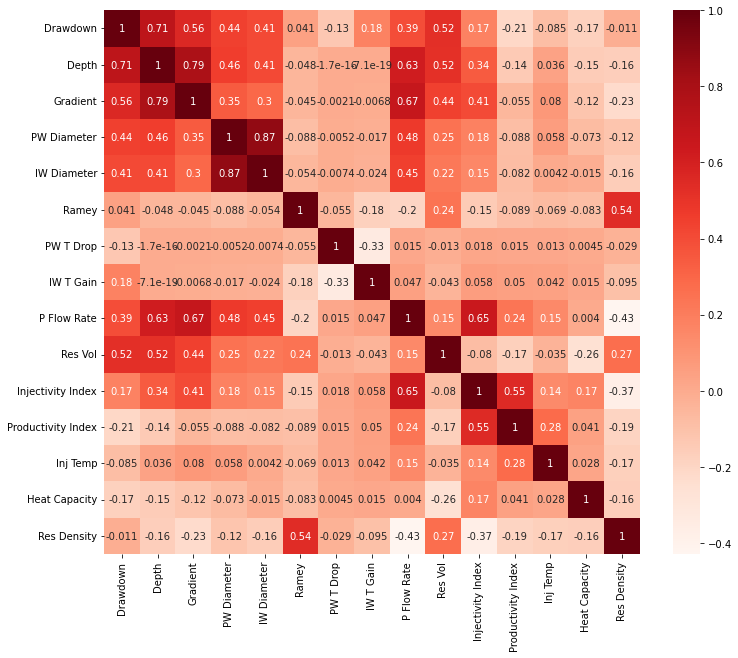

In [10]:
df_pred.corr()
plt.figure(figsize = (12, 10))
sb.heatmap(df_pred.corr(), cmap="Reds", annot=True)

**►** The Ramey's model is a Boolean variable; 1 means it will be used to estimate the geofluid
temperature drop in the production wells. 0 means the simulation will not use the Ramey's model and will read the manual entries of *production well temperature drop* ('PW T Drop'), *injection well temperature gain* ('IW T Gain') columns. We choose to disregard these parameters for this study as they are not primary factors in the subsurface heat transfer processes.

In [11]:
# remove Ramey's model, and wellbore temprature loss/gain from predictor features 

features = df_pred.drop(['Ramey', 'PW T Drop','IW T Gain'], axis=1)

#features = df_pred
features.head(n=3)

,Drawdown,Depth,Gradient,PW Diameter,IW Diameter,P Flow Rate,Res Vol,Injectivity Index,Productivity Index,Inj Temp,Heat Capacity,Res Density
0,0.0050,2.0,65.0,9.625,9.625,110,1000000000,10,10,70,1050,2700
1,0.0075,2.0,65.0,9.625,9.625,110,1000000000,10,10,70,1050,2700
2,0.0050,2.5,65.0,9.625,9.625,110,1000000000,10,10,70,1050,2700


**►** The correlation matrix for the response features shows strong correlation between Average Net Electricity generation and total capital cost and annual operating and maintenace cost (presented in the following plot):

<AxesSubplot:>

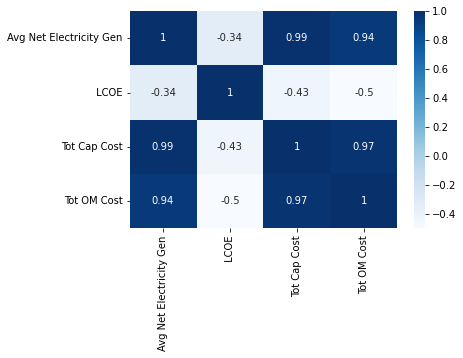

In [12]:
sb.heatmap(df_resp.corr(), cmap="Blues", annot=True)

**►** We create the following pairwise relationships for the predictor features to get an overview of the data:

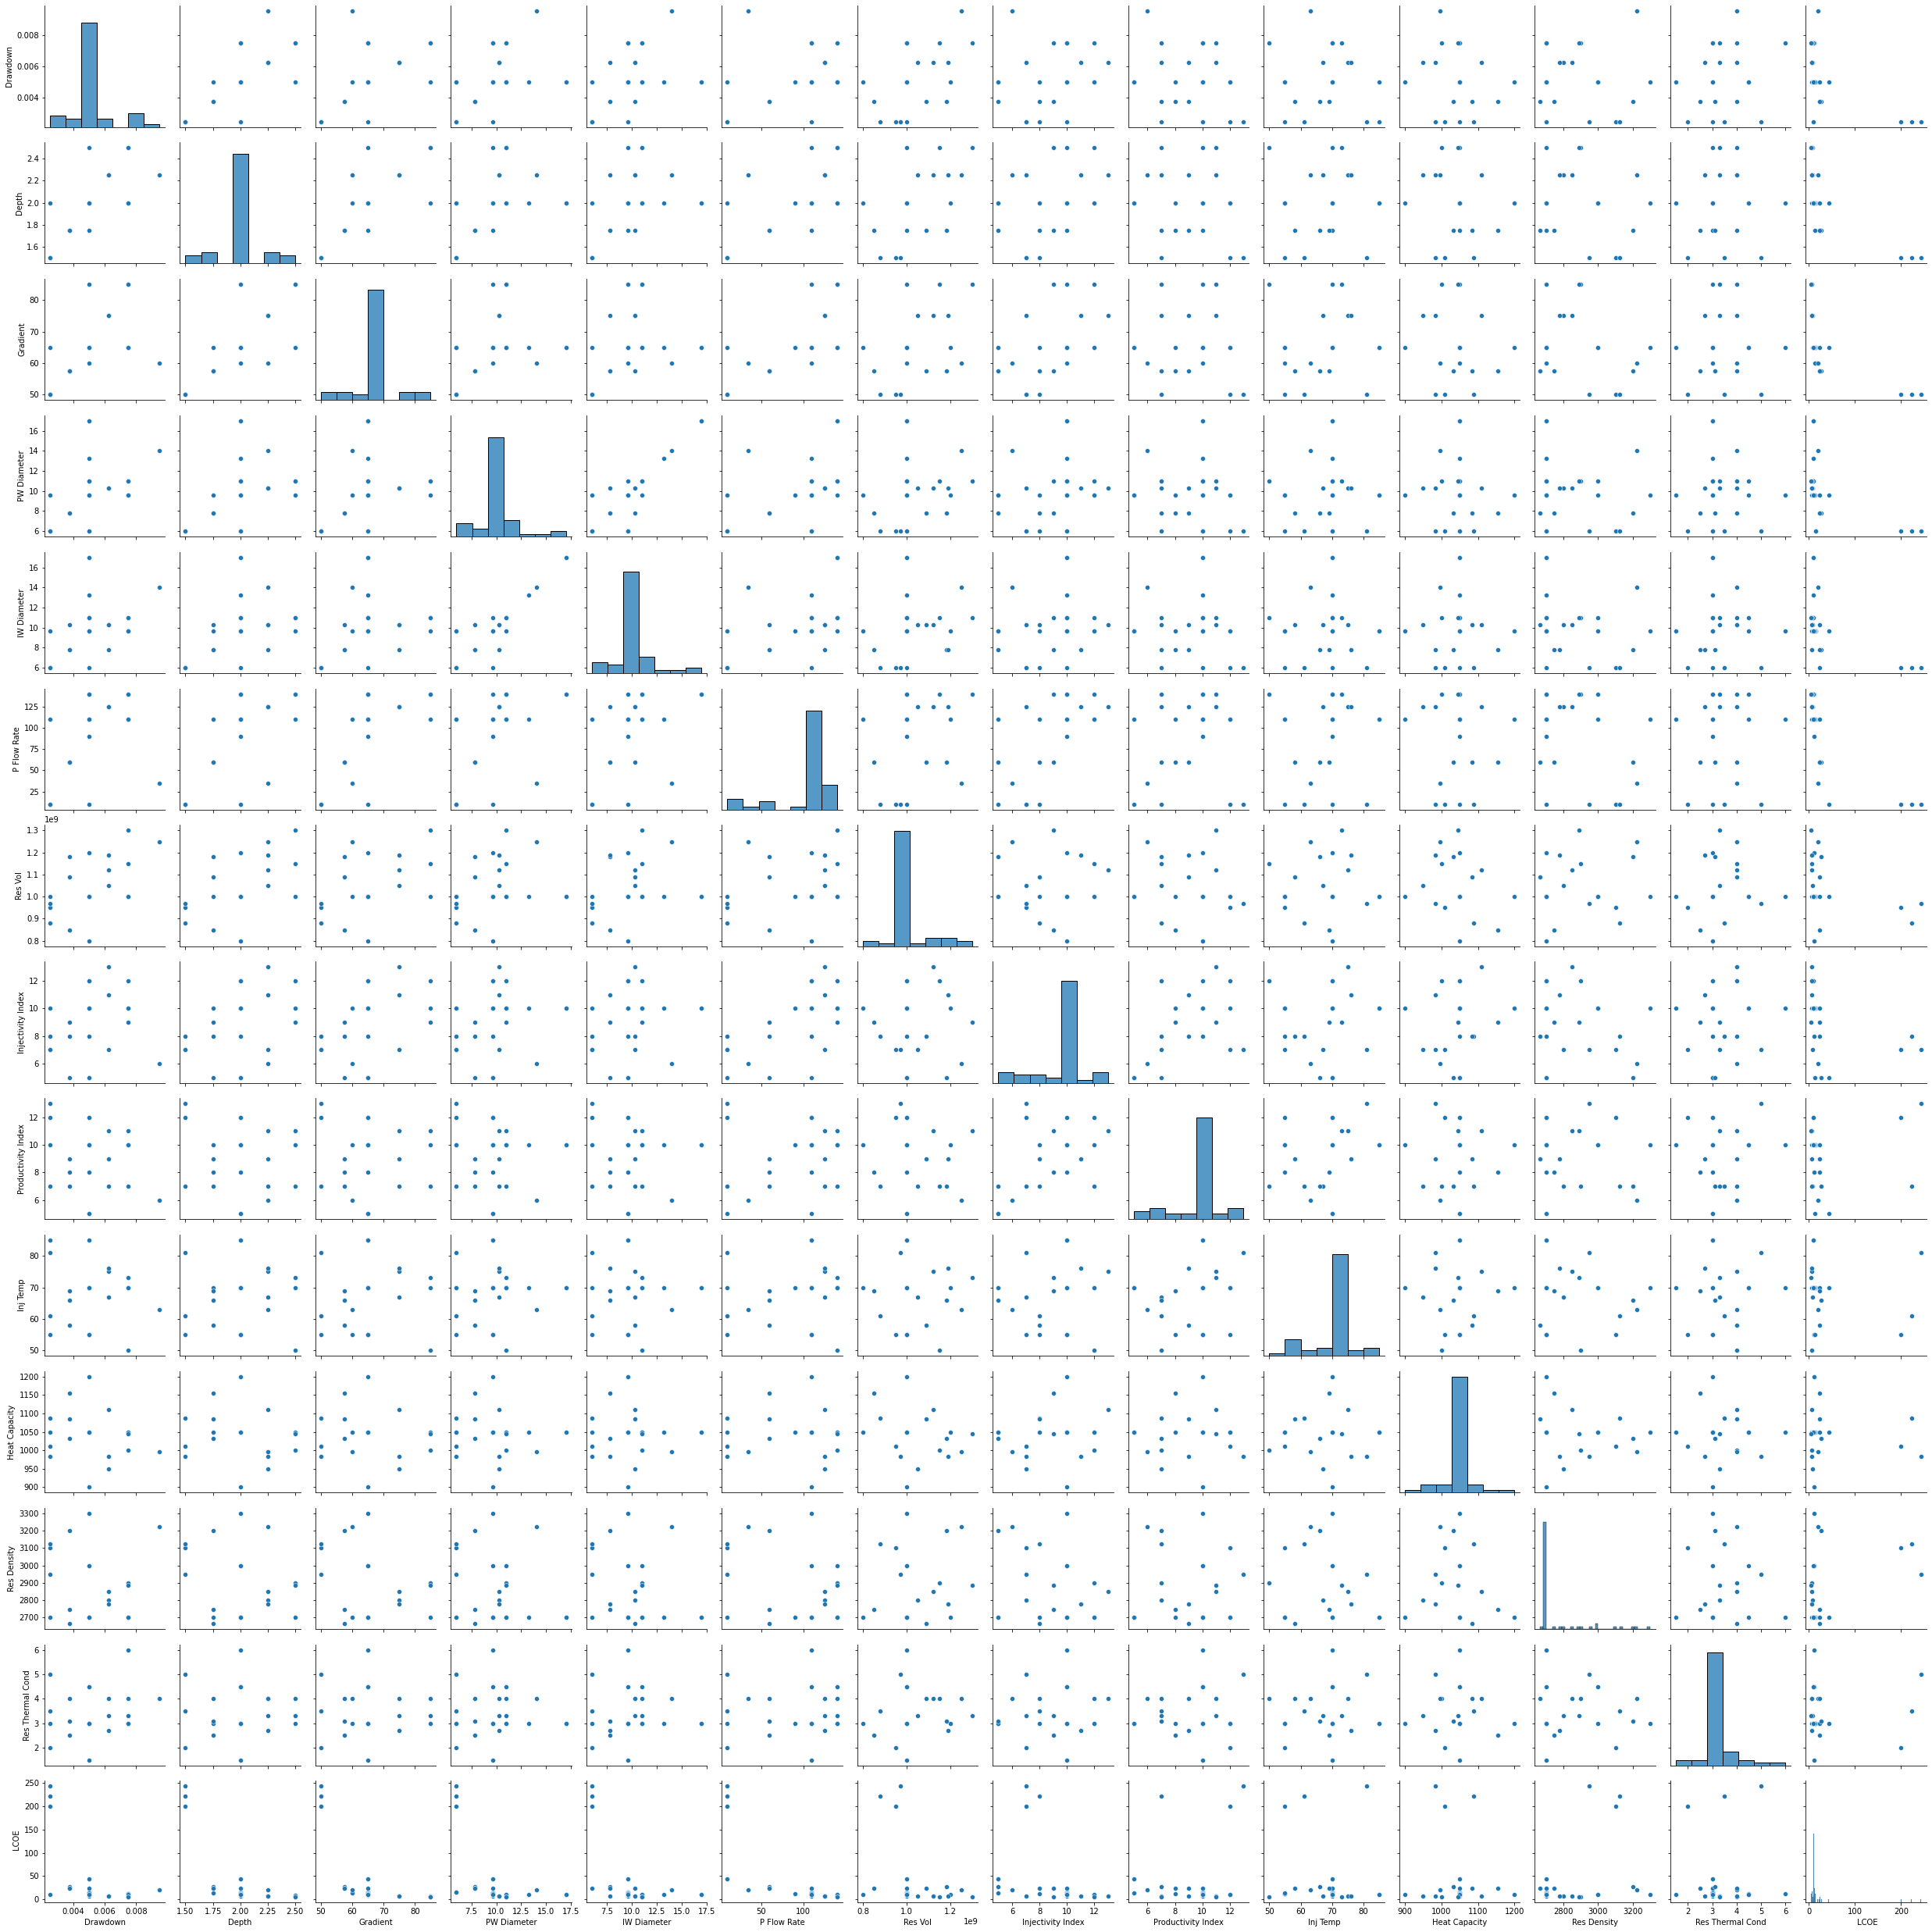

In [13]:
sb.pairplot(df,vars=['Drawdown', 'Depth' ,'Gradient', 'PW Diameter', 'IW Diameter',
                      'P Flow Rate', 'Res Vol', 'Injectivity Index', 'Productivity Index' ,'Inj Temp', 'Heat Capacity'
                      , 'Res Density', 'Res Thermal Cond', ' LCOE'],markers='o')

**►** The predictor features show adequate coverage of a range of parameters. Inspecting the last row of plots (the response feature of interest vs predictors) reveals that *LCOE* is NOT linearly correlated with the predictors.

**►** Now we will look at the response features only. 

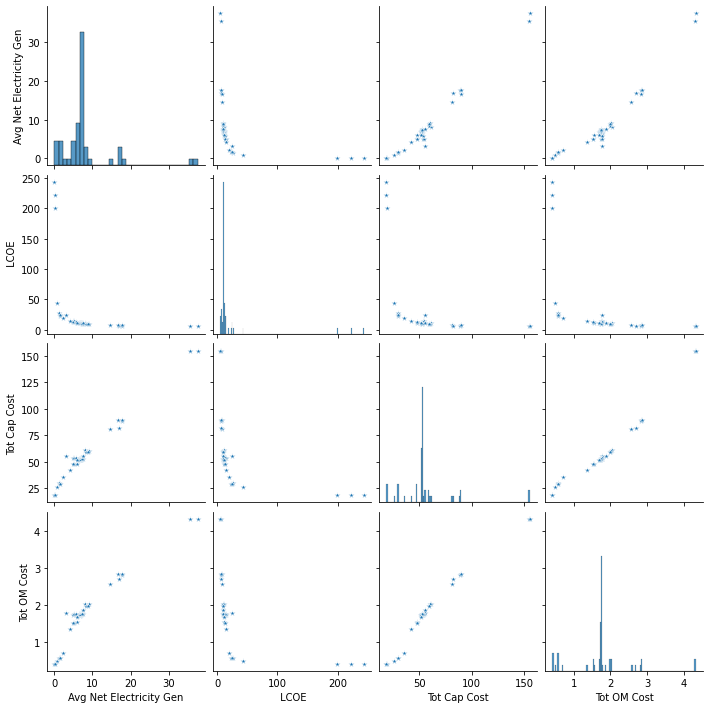

In [14]:
sb.pairplot(df,vars=['Avg Net Electricity Gen',' LCOE','Tot Cap Cost','Tot OM Cost'],markers='*')

**►** Total capital cost and annual O&M costs are highly correlated with Average Net Electricty Generation, thus if there is interest in building regression models for paramters other than LCOE, we suggest selecting Average Net Electricty Generation as the response feature and use its correlations to predict total capital cost and annual O&M costs.

In [15]:
responses = df_resp.drop(['Tot Cap Cost','Tot OM Cost'], axis=1)
responses.head()

,Avg Net Electricity Gen,LCOE
0,6.96,10.8
1,6.41,11.5
2,14.65,7.8
3,16.84,6.9
4,7.05,10.7


**►** Let's create the training and testing data for the regression methods under consideration. We use a 70/30 split and we chose the random state to ensure a fair training/testing coverage of data. Note that the reponse feature is *LCOE*.

In [16]:
x, y = features, responses[' LCOE']
x_train, x_test, y_train, y_test = train_test_split(features, responses[' LCOE'], train_size = 0.7, random_state = 111)
y_train.head(n=5)

9     10.8
42     7.5
3      6.9
4     10.7
11    10.7
Name:  LCOE, dtype: float64

**►** Let's look at the histogram of the traning data, there is a single datapoint near 200 and the rest are less than 50 cents/kilowatts.

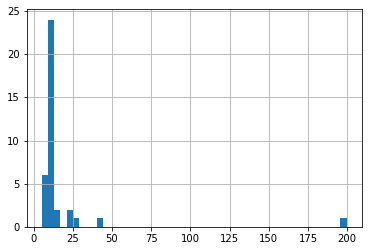

In [17]:
hist = y_train.hist(bins=50)

**►** The testing data has the same quality, two datapoints between 200-250 and the rest of the data is less than 50 cents/kilowatts. 

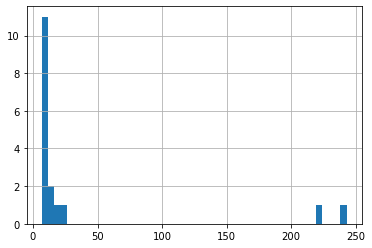

In [18]:
hist = y_test.hist(bins=50)

**►** We now compare the training and testing data below 50 to ensure the overlap in coverage is adequate. 

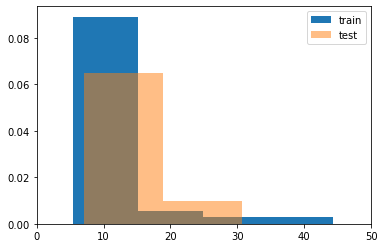

In [19]:
plt.hist(y_train, 20, density=True, label='train')
plt.hist(y_test, 20, alpha=0.5, density=True, label='test')
plt.xlim([0,50])
plt.legend()
plt.show()

**►** Let's look at the histogram of predictor features in the training set.

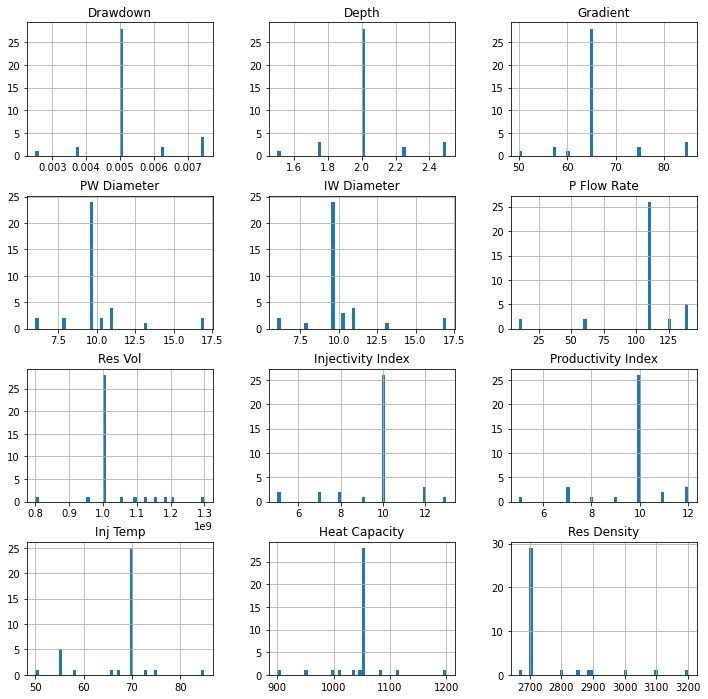

In [20]:
hist = x_train.hist(bins=50, figsize=(12,12))

**►** Let's look at the histogram of preductor features in the testing set. The train/test seems to be in good shape. 

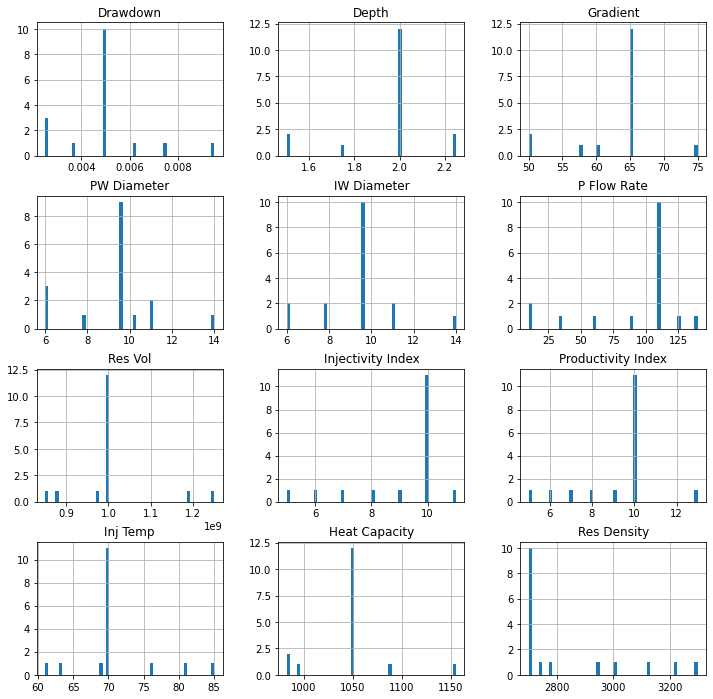

In [21]:
hist = x_test.hist(bins=50, figsize=(12,12))

**►** Normalize the train/test predictor features using min-max scaler:

In [22]:
#normalize train/test features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

### 2.  Non-bagged Regression Methods 

**►** In this section, We will train the following regression methods and assess their performance on the testing data:

* **Linear Regression** - Our good old friend Lin Reg
* **Ridge Regression** - Regularized lin. reg. with L2 norm 
* **Lasso Regression** - Regularized lin. reg. with L1 norm
* **ElasticNet** - combined L1 and L2 norms as regularizers, gridsearch applied without success to tune hyperparameters
* **Polynomial Regression** - polynomial expansion of the features, response is still predicted as a weighted linear combination of the predictors (linear regression). 
* **DecisionTree** - A decision tree model with max. depth of 3

**►** Let's start with a brief explnanation of the linear regression method; this method uses a weighted sum of predictor features to estimate the response:

$\hat{Y} = \hat{\beta}_{0} + \sum \limits _{j=1} ^{p} X_{j}\hat{\beta}_{j} $

Where Y = response, X = predictor, *β* = regression coeff. 

To aquire the regression coefficients, the prediction error i.e. residual sum of suqares is minimized:

$ RSS = \sum \limits _{i=1}^n (y_i - (\sum \limits _{j = 1}^m \beta_{j} x_{j} + \beta_0))^2 $

See below for the results of this method:

In [23]:
# Linear Regression Model
lr = LinearRegression()

#Fit model
lr.fit(X_train, y_train)

# Return the coefficient of determination (R2) of the predictions for training and testing sets
train_score_lr = lr.score(X_train, y_train)
test_score_lr = lr.score(X_test, y_test)

print("\nLinear Regression Model............................................\n")
print("The train score for lr model is {}".format(train_score_lr))
print("The test score for lr model is {}".format(test_score_lr))


Linear Regression Model............................................

The train score for lr model is 0.7995659589564647
The test score for lr model is 0.5633794344725662


**►** Let's take a look at LCOE predcitions for test data by linear regression. The negative values are physically meaningless and of no use. 

In [24]:
yhat0 = lr.predict(X_test)
print(yhat0[:])

[ 9.96923128e+01  6.12411420e+01  1.06764209e+01  1.06764209e+01
  1.06764209e+01  2.74279663e+01  1.06764209e+01  1.33590529e+02
 -5.23247458e+00  8.47348323e+01 -6.19808985e-03  1.35565459e+01
 -3.91486879e+01  1.34015034e+01  1.27041901e+01  3.00554769e+01
 -9.61742061e+00]


**►** Let's try the ridge and lasso methods next, in these two methods, L2 and L1 norms are used for regularization. 

The function to minimize for ridge:


$\sum \limits _{i=1}^n (y_i - (\sum \limits _{j = 1}^m \beta_{j} x_{j} + \beta_0))^2 + \lambda \sum \limits_{j=1}^m \beta_{j}^2 $


The function to minimize for lasso:

$\sum \limits _{i=1}^n (y_i - (\sum \limits _{j = 1}^m \beta_{j} x_{j} + \beta_0))^2 + \lambda \sum \limits_{j=1}^m |\beta_{j}|$

In both cases: *λ* = hyperparameter 

several values for the hyperparameter ("alpha" in the code) were tried to improve the $R^{2}$ score, though no significant improvement is achieved over linear regression. 

In [25]:
# code from https://www.datacamp.com/tutorial/tutorial-lasso-ridge-regression
#Ridge Regression Model
ridgeReg = Ridge(alpha=0.1)

ridgeReg.fit(X_train,y_train)

#train and test scorefor ridge regression
train_score_ridge = ridgeReg.score(X_train, y_train)
test_score_ridge = ridgeReg.score(X_test, y_test)

print("\nRidge Model............................................\n")
print("The train score for ridge model is {}".format(train_score_ridge))
print("The test score for ridge model is {}".format(test_score_ridge))

#Lasso regression model
print("\nLasso Model............................................\n")
lasso = Lasso(alpha = 0.08)
lasso.fit(X_train,y_train)
train_score_ls =lasso.score(X_train,y_train)
test_score_ls =lasso.score(X_test,y_test)

print("The train score for ls model is {}".format(train_score_ls))
print("The test score for ls model is {}".format(test_score_ls))


Ridge Model............................................

The train score for ridge model is 0.7907321255972058
The test score for ridge model is 0.5698538761506786

Lasso Model............................................

The train score for ls model is 0.7942619184192032
The test score for ls model is 0.5672696432726916


**►** Let's try the combination of L1 and L2 regularizations i.e. ElasticNet regression, see the [documentation](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net) in scikit-learn package to learn more about the form the objective function being minimized. In summary, in addition to "*alpha*", another hyperparameter "*l1_ratio*" controls the convex combination of L1 and L2 regularizations.

Results show marginal improvment over ridge, lasso and linear regression methods (slightly better $R^{2}$ value).

In [27]:
# define model
model = ElasticNet()

# define grid
grid = dict()
grid['alpha'] = [1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = np.arange(0, 1, 0.05)

# define evaluation
cv = RepeatedKFold(n_splits=4, random_state=111)

# define search
#search = GridSearchCV(model, grid, scoring='r2')
search = GridSearchCV(model, grid, cv=cv)

#normalize predictor features
scaler1 = MinMaxScaler()
X = scaler1.fit_transform(x)

# perform the search
result = search.fit(X, y)

# summarize result
print("\nOptimized Elastic Net............................................\n")
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

# print("The train score for enet model is {}".format(train_score_enet1))
# print("The test score for enet model is {}".format(test_score_enet1))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.735e+03, tolerance: 3.596e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.308e+03, tolerance: 1.239e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea


Optimized Elastic Net............................................

Best Score: -3.4832548870800437
Best Hyperparameters: {'alpha': 1.0, 'l1_ratio': 0.75}


**►** Gridsearch did not converge to optimize the hyperparameters for ElasticNet. We instead use hyperparameters close to what we used in ridge and lasso and the corresponding $R^{2}$ value is close to those of the previous regression methods. 

In [28]:
enet2 = ElasticNet(alpha=0.0086, l1_ratio=0.9)
enet2.fit(X_train, y_train)

train_score_enet2 = enet2.score(X_train, y_train)
test_score_enet2 = enet2.score(X_test, y_test)

print("\nOptimized Elastic Net............................................\n")
print("The train score for enet model is {}".format(train_score_enet2))
print("The test score for enet model is {}".format(test_score_enet2))


Optimized Elastic Net............................................

The train score for enet model is 0.7978829477880706
The test score for enet model is 0.5677514596084303


**►** Next, we try polynomial regression with ridge to linearly estimate the response. In this method, each feature is expanded to take a polynomial form:

$h_{j,k}(X_j) = X_j^k$

The response is still estimated via a linear regression of the transformed features.

$ y = f(x) = \sum \limits _{j=1}^{m} \sum \limits _{k = 1}^{K} \beta_{j,k} h_{j,m}(X_j) $

*K* = degree of the polynomial

Maximum degree of the polynomial was changed between 2-6 and the one with the best $R^{2}$ for test data was selected (which is two). The performance of this method is much better than the previous non-bagged methods in this section. This may be attributed to the capture of non-linearity via this method.

In [29]:
polynomial_regressor = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=2),
    Ridge(alpha=4e-2),
)
  
poly_ = polynomial_regressor.fit(x_train, y_train)


#train and test score for poly ridge regression
train_score__poly = poly_.score(x_train, y_train)
test_score__poly = poly_.score(x_test, y_test)

print("\n Ridge Polynomial Model............................................\n")
print("The train score for bagged poly model is {}".format(train_score__poly))
print("The test score for bagged poly model is {}".format(test_score__poly))


 Ridge Polynomial Model............................................

The train score for bagged poly model is 0.9962335328991161
The test score for bagged poly model is 0.7588176030150298


**►** finally in this section, we apply a decision tree (DT) model to perform the regression. DT is a nonparametric model that operates based on rules inferred from segmenting the predictor feature space. A DT model can also be viewed as a piecewise multiple step function approximation.

When applied to our dataset, the testing performance of the DT model is slightly worse than previous parametric models (despite having an almost perfect training score).

In [30]:
#Decision Tree Regression Model
DTReg = DecisionTreeRegressor(max_depth=3, random_state=37)

DTReg.fit(X_train,y_train)

#train and test scorefor ridge regression
train_score_DTReg = DTReg.score(X_train, y_train)
test_score_DTReg = DTReg.score(X_test, y_test)

print("\nDec. Tree Model............................................\n")
print("The train score for ridge model is {}".format(train_score_DTReg))
print("The test score for ridge model is {}".format(test_score_DTReg))


Dec. Tree Model............................................

The train score for ridge model is 0.9958360030761846
The test score for ridge model is 0.5466257461034811


### 3.  Bagged and Ensemble Regression Methods 

In this section, We will train the following regression methods and assess their performance on the testing data:

* **Bagged Polynomial Regression** - Bagged version of poly regression
* **Bagged Decision Tree Regression** - Bagged version of decision tree regression
* **Random Forest Regression** - ensemble method
* **Bootstrapped training data** - ridge regression applied to 1000 realization of train/test data

**►** In order to explain how bagging works, we first introduce the concept of *bootstrapping*. Bootstrapping is a method to generate many simulated subsets from an existing dataset. The subsets consist of data sampled from the original dataset but with each datum returning to the pool and having the possibility of being sampled again. Bagging uses bootstrapping to train several models on the training sets obtained through bootstrapping. The predictions of all these "sub-models" are aggregated to produce the final estimation for the response.

**►** Polynomial regression method was introduced earlier. The polynomial regression (from the end of previous section) is bagged; max. degrees of 2-6 were tried to get the best testing score. Surprisingly, the performance is worse than a single polynomial regressor. This may be due to higher sensitivity of nonlinear portion of the model to the bagged training sets and could be investigated further.

In [31]:
polynomial_regressor = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=2),
    Ridge(alpha=4e-2),
)

bagging_poly = BaggingRegressor(
    base_estimator=polynomial_regressor,
    n_estimators=100,
    random_state=111,
)
__ = bagging_poly.fit(x_train, y_train)

#train and test scorefor ridge regression
train_score_bagging_poly = __.score(x_train, y_train)
test_score_bagging_poly = __.score(x_test, y_test)

print("\nBagged Polynomial Model............................................\n")
print("The train score for bagged poly model is {}".format(train_score_bagging_poly))
print("The test score for bagged poly model is {}".format(test_score_bagging_poly))


Bagged Polynomial Model............................................

The train score for bagged poly model is 0.8672831130346195
The test score for bagged poly model is 0.5564666367515189


**►** Next, a decision tree model is bagged. Max depth of tree was varied between 1-8 to find the highest coefficient of determination for test data (avoiding diminishing returns in increasing $R^{2}$ was taken into consideration).

In [32]:
bagged_trees = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=1),
    n_estimators=100, random_state=37)

_ = bagged_trees.fit(X_train,y_train)

#train and test scorefor ridge regression
train_score_bagged = _.score(X_train, y_train)
test_score_bagged = _.score(X_test, y_test)

print("\nBagged Trees Model............................................\n")
print("The train score for bagged trees model is {}".format(train_score_bagged))
print("The test score for bagged trees model is {}".format(test_score_bagged))


Bagged Trees Model............................................

The train score for bagged trees model is 0.8788631773662317
The test score for bagged trees model is 0.6984768938393959


**►** We then try the random forest regression. In this model, an ensemble of trees are generated but the unique feature is the selection of subset of features (randomly selected) to build the tree. This induced diversity in evolution makes the ensemble qualitatively more heterogeneous and helps with the fit quality.

Let us see now if the wisdom of all present in this dark room is able to describe the form of an [elephant](https://regworldlit.files.wordpress.com/2013/10/elephant-in-the-dark-text-of-poem.pdf)! Max. depth of tree was varied between 1-8 to find the highest coefficient of determination for test data.

In [33]:
rndfrst_regr = RandomForestRegressor(max_depth=1, random_state=37)
___ = rndfrst_regr.fit(X_train,y_train)

#train and test score for random forest regression
train_score_rndf = ___.score(X_train, y_train)
test_score_rndf = ___.score(X_test, y_test)

print("\nRandom Forest Model............................................\n")
print("The train score for random forest model is {}".format(train_score_rndf))
print("The test score for random forest model is {}".format(test_score_rndf))


Random Forest Model............................................

The train score for random forest model is 0.8829960454720563
The test score for random forest model is 0.7190030818770012


**►** Finally, we perform bootstrapping (sampling with replacement) on training/testing data to aquire a distribution for the fit quality. The regressor of choice here is ridge.

In [34]:
# re-instanstiate your estimator
#linreg = LinearRegression()
linreg = Ridge()

# code adapted from https://ethanwicker.com/2021-02-23-bootstrap-resampling-001/      
data = pd.concat(objs=[features, responses[' LCOE']], axis=1)

# Defining number of iterations for bootstrap resample
n_iterations = 1000

# Initializing DataFrame, to hold bootstrapped statistics
bootstrapped_stats = pd.DataFrame()

col = ' LCOE'
train_mse = {}
test_mse = {}
train_r2 = {}
# Each loop iteration is a single bootstrap resample and model fit
for i in range(n_iterations):

    # Sampling n_samples from data, with replacement, as train
    # Defining test to be all observations not in train
    train = resample(data, replace=True, n_samples=len(data))
    test = data[~data.index.isin(train.index)]

    x_train = train.loc[:, train.columns != col]
    y_train = train.loc[:, [' LCOE']]
    X_train = scaler.fit_transform(x_train)


    x_test = test.loc[:, test.columns != col]
    y_test = test.loc[:, [' LCOE']]
    X_test = scaler.transform(x_test)

    # Fitting linear regression model
    linreg.fit(X_train, y_train)
    
    # predict the data
    y_train_pred = linreg.predict(X_train)
    y_test_pred  = linreg.predict(X_test)

    # Storing stats in DataFrame, and concatenating with stats
    intercept = linreg.intercept_
    r_squared = linreg.score(X_test, y_test)
    
    train_mse[i] = mean_squared_error(y_train, y_train_pred)
    test_mse[i]  = mean_squared_error(y_test, y_test_pred)
    train_r2[i]  = linreg.score(X_train, y_train)

    bootstrapped_stats_i = pd.DataFrame(data=dict(
        intercept=intercept,
        r_squared=r_squared
    ))

    bootstrapped_stats = pd.concat(objs=[bootstrapped_stats,
                                         bootstrapped_stats_i])

**►** Histogram for coeff. of determination of the training sets:

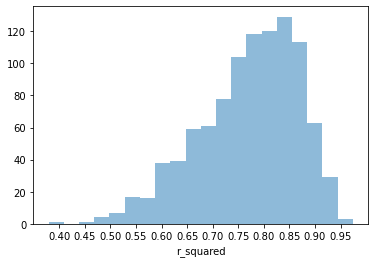

In [37]:
plt.hist(train_r2.values(), 20, density=False, alpha=0.5)
plt.xticks(np.arange(0.4, 1, step=0.05))  # Set label locations.
plt.xlabel('r_squared')
plt.show();

**►** Histogram for the intercept (left) & coeff. of determination of the testing sets (right):

(-1.0, 1.0)

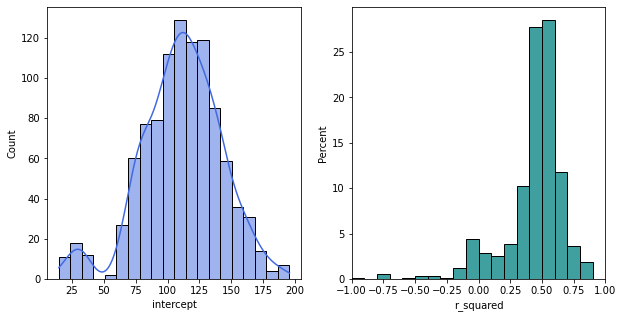

In [38]:
# Plotting histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sb.histplot(bootstrapped_stats["intercept"], color="royalblue", bins=20, ax=ax1 , kde=True)
sb.histplot(bootstrapped_stats["r_squared"], color="teal", bins=20, ax=ax2, binrange=(-1,1), kde=False, stat='percent')
ax2.set_xlim(-1,1)

**►** Note the negative $R^{2}$ values in the plot on the right hand side. Apparently a negative $R^{2}$ is not an impossibility. When the fit does not follow the trend of the data meaning when it is worse than an average value (a horizotal line in the bivariate scenario), $R^{2}$ will become a negative number. For more info, see [here](https://stats.stackexchange.com/questions/12900/when-is-r-squared-negative/12991#12991).

In the above workflow (bootstrapped training/testing data), if we use linear regression (currently commented out) instead of ridge, the percentage of negative $R^{2}$ dramatically increases; this indicates the regularization is advantageous in dealing with this particular dataset. 

### 4. Key Takeaways 

<font color='green'> __* <u>*Linear non-bagged*</u> regressors struggled with the dataset under study. During the inspection of the dataset, we did notice the non-linear nature of the correlation between the predictors and the response.__ </font>

<font color='green'> __* The polynomial regressor performed better than other <u>*non-bagged*</u> methods in section 2; we propose this is due to its adaptivity at tackling <u>nonlinear</u> behavior.__ </font>

<font color='green'> __* The performance of the polynomial regressor (<u>nonlinear</u>) when <u>bagged</u> worsened compared to the <u>*non-bagged*</u> polynomial method; we suggest this is due to the higher sensitivity of nonlinear models to "bad" training data generated by bootstrapping as a part of bagging. But a more definitive statement demands further investigation.__ </font>

<font color='green'> __* Wisdom of the crowd: <u>non-parametric bagged/ensemble</u> methods scored better in generalization when tackling a high dimensional and sparse dataset. In this workflow, their performance  was better than when a single regressor was used to predict the response (with the exception of polynomial regressor).__ </font>

<font color='green'>  __* Bootstrapping the training (and testing) data provided a confidence interval on the quality of the <u>*linear*</u> fit. The mode of this distrbution was on par with the $R^{2}$'s obtained for non-bagged linear, ridge, lasso and elastic net methods.__ <font color='red'>

| Regression Method | Bagged Type | Linearity | Parametric | $R^{2}$ Score - Training | $R^{2}$ Score - Testing |
| --- | --- | --- | --- | --- | --- |
| Linear reg.  | Non-bagged | Linear | Parametric | 0.7996 | 0.5633 | 
| Ridge  | Non-bagged | Linear | Parametric | 0.7907 |  0.5699 |
| Lasso  | Non-bagged | Linear | Parametric | 0.7943 | 0.5673 |
| Elastic Net  | Non-bagged | Linear | Parametric | 0.7979 | 0.5676 |
| Polynomial (w/ Ridge)  | Non-bagged | Non-linear | Parametric |0.9962 | 0.7588 |
| Decision Tree  | Non-bagged | NA | Non-parametric |0.9958 | 0.5466 |
| Polynomial (w/ Ridge) | Bagged | Non-linear | Parametric | 0.8672 | 0.5565 |
| Decision Tree  | Bagged | NA | Non-parametric |0.8789 | 0.6985 |
| Random Forest  | Ensemble | NA | Non-parametric |0.8830 | 0.7190 |
| Bootstrapped Ridge | Bagged | Linear | Parametric |0.80-0.85* | 0.50-0.60* |

<sup>*distribution mode </sup>

<font color='green'> __* Bootstrapping also indicated the importance of regularization to stablize the regression model. Without regularization, the probability of having a negative $R^{2}$ increases.__ <font color='red'>

<h1><center>
    

**►** __This workflow was prepared during Fall 2022 semester by:__

## KEIVAN KHALEGHI 
### PhD Student at the University of Texas at Austin 

Connect with me! I am interested in all things energy and creative endeavours.  

##### [Twitter](https://twitter.com/kkhlgh) | [GitHub](https://github.com/KKhaleghi)  | [GoogleScholar](https://scholar.google.com/citations?user=KCnuuLMAAAAJ&hl=en) | [LinkedIn](https://www.linkedin.com/in/keivan-khaleghi/)

</center></h1>

$_{Ad Astra Abyssosque...}$